# Normal NN MNIST

I want the sterotypical NN here. We'll use 3blue1brown's design. This will be our baseline before diving into adding all of the SAE/transcoder/deep supervision fluff.

In [1]:
import time

EXPERIMENT_TYPE = "standard"
RUN_ID = time.time()

## Imports

In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [3]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cpu


## Load Data

In [5]:
# train data
train_images = load_images("../data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [6]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

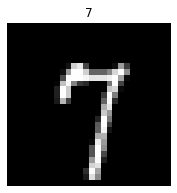

In [7]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

# Helper to Plot Weights

In [8]:
# Graphing code to visualize weights
def plot_weights(model, epoch):
    save_path_hidden_one = f'./weights/{EXPERIMENT_TYPE}/{RUN_ID}/hidden_one/hidden_one_weights_{epoch + 1}.png'
    save_path_classification = f'./weights/{EXPERIMENT_TYPE}/{RUN_ID}/classification/classification_weights_{epoch + 1}.png'
    save_path_hidden_two = f'./weights/{EXPERIMENT_TYPE}/{RUN_ID}/hidden_two/hidden_two_weights_{epoch + 1}.png'

    for path in [save_path_hidden_one, save_path_hidden_two, save_path_classification]:
        os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Extract weights from each layer
    hidden_one_w = model.hidden_one.weight.detach().cpu().numpy()  # Shape: (16, 784)
    hidden_two_w = model.hidden_two.weight.detach().cpu().numpy()  # Shape: (16, 16)
    classification_w = model.classification_layer.weight.detach().cpu().numpy()  # Shape: (10, 16)

    # Figure 1: Hidden One Weights (4x4 grid of 28x28 images)
    fig1, axes1 = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        row, col = divmod(i, 4)
        neuron_w = np.abs(hidden_one_w[i].reshape(28, 28))  # Reshape to 28x28
        axes1[row, col].imshow(neuron_w, cmap='gray')
        axes1[row, col].set_title(f"H1 Neuron {i+1}")
        axes1[row, col].axis('off')
    plt.suptitle(f"Hidden One Weights - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(save_path_hidden_one)
    plt.close()

    # Figure 2: Hidden Two Weights (4x4 grid of line plots)
    # TODO: change this to scatter plot (these should be disrete data points)
    fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
    min_w = hidden_two_w.min()
    max_w = hidden_two_w.max()
    for i in range(16):
        row, col = divmod(i, 4)
        axes2[row, col].plot(hidden_two_w[i])
        axes2[row, col].set_title(f"H2 Neuron {i+1}")
        axes2[row, col].set_xlabel("From H1 Neuron")
        axes2[row, col].set_ylabel("Weight")
        axes2[row, col].set_ylim(min_w, max_w)
    plt.suptitle(f"Hidden Two Weights - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(save_path_hidden_two)
    plt.close()

    # Figure 3: Classification Weights (2x5 grid of line plots)
    fig3, axes3 = plt.subplots(2, 5, figsize=(15, 6))
    min_w = classification_w.min()
    max_w = classification_w.max()
    for j in range(10):
        row, col = divmod(j, 5)
        axes3[row, col].plot(classification_w[j])
        axes3[row, col].set_title(f"Class {j}")
        axes3[row, col].set_xlabel("From H2 Neuron")
        axes3[row, col].set_ylabel("Weight")
        axes3[row, col].set_ylim(min_w, max_w)
    plt.suptitle(f"Classification Weights - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(save_path_classification)
    plt.close()

## Architecture

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [10]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [12]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]


### Verify Reproducibility

In [13]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [14]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [15]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [16]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

In [17]:
best_model = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()
        total_loss = classification_loss_fn(classification_out, labels)
        total_loss.backward()
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = model
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = model

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    plot_weights(model, epoch)

Epoch 1/20
  Train Loss: 1.0131
  Val Loss: 0.5521 | Val Acc: 83.76%
  Saved model with Val Acc: 83.76%


Epoch 2/20
  Train Loss: 0.4601
  Val Loss: 0.4512 | Val Acc: 86.42%
  Saved model with Val Acc: 86.42%


Epoch 3/20
  Train Loss: 0.4093
  Val Loss: 0.4022 | Val Acc: 87.76%
  Saved model with Val Acc: 87.76%


Epoch 4/20
  Train Loss: 0.3899
  Val Loss: 0.4044 | Val Acc: 87.80%
  Saved model with Val Acc: 87.80%


Epoch 5/20
  Train Loss: 0.3708
  Val Loss: 0.3718 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


Epoch 6/20
  Train Loss: 0.3590
  Val Loss: 0.3640 | Val Acc: 89.51%
  Saved model with Val Acc: 89.51%


Epoch 7/20
  Train Loss: 0.3511
  Val Loss: 0.3932 | Val Acc: 88.37%


Epoch 8/20
  Train Loss: 0.3440
  Val Loss: 0.3642 | Val Acc: 89.00%


Epoch 9/20
  Train Loss: 0.3392
  Val Loss: 0.3668 | Val Acc: 89.01%


Epoch 10/20
  Train Loss: 0.3337
  Val Loss: 0.3616 | Val Acc: 89.52%
  Saved model with Val Acc: 89.52%


Epoch 11/20
  Train Loss: 0.3278
  Val Loss: 0.3636 | Val Acc: 89.26%


Epoch 12/20
  Train Loss: 0.3276
  Val Loss: 0.3588 | Val Acc: 89.54%
  Saved model with Val Acc: 89.54%


Epoch 13/20
  Train Loss: 0.3246
  Val Loss: 0.3596 | Val Acc: 89.44%


Epoch 14/20
  Train Loss: 0.3221
  Val Loss: 0.3644 | Val Acc: 89.28%


Epoch 15/20
  Train Loss: 0.3212
  Val Loss: 0.3651 | Val Acc: 89.16%


Epoch 16/20
  Train Loss: 0.3165
  Val Loss: 0.3507 | Val Acc: 89.55%
  Saved model with Val Acc: 89.55%


Epoch 17/20
  Train Loss: 0.3181
  Val Loss: 0.3458 | Val Acc: 90.06%
  Saved model with Val Acc: 90.06%


Epoch 18/20
  Train Loss: 0.3160
  Val Loss: 0.3437 | Val Acc: 89.84%


Epoch 19/20
  Train Loss: 0.3143
  Val Loss: 0.3601 | Val Acc: 89.45%


Epoch 20/20
  Train Loss: 0.3108
  Val Loss: 0.3599 | Val Acc: 89.85%


# Training Exploration

In [18]:
def plot_losses(training_loss, validation_loss):
    epochs = np.arange(1, len(validation_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_losses, 'b-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

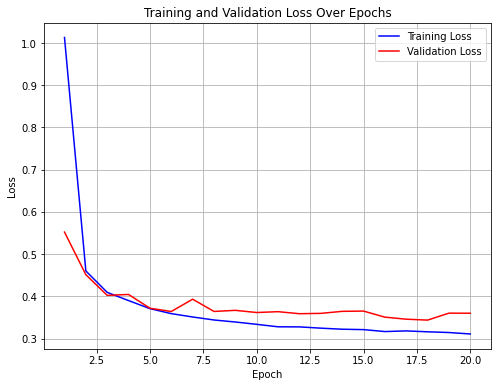

In [19]:
plot_losses(training_losses, validation_losses)

## Eval

In [20]:
best_model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = best_model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|███████████████████████████████████████████████████| 79/79 [00:00<00:00, 365.73it/s]

Final Test Accuracy: 90.33%


# Activation Exploration

## Helper to visualize Activations

In [56]:
def plot_activations(hidden_one_act, hidden_two_act, classification_out, label, save_plt=False, meta=None):
    if meta:
        label = f"{label}_{meta}"
        
    # Convert tensors to numpy arrays
    hidden_one_act_np = hidden_one_act.cpu().detach().numpy()
    hidden_two_act_np = hidden_two_act.cpu().detach().numpy()
    classification_act_np = classification_out.cpu().detach().numpy()
    
    # Squeeze any singleton dimensions (e.g., (1, 16) -> (16,))
    hidden_one_act_np = np.squeeze(hidden_one_act_np)
    hidden_two_act_np = np.squeeze(hidden_two_act_np)
    classification_act_np = np.squeeze(classification_act_np)
    
    def normalize(acts):
        # Handle scalar or single-value arrays
        if acts.size == 1:
            return np.array([0.5])  # Map to middle of colormap
            
        # Add epsilon to avoid division by zero
        return (acts - acts.min()) / (acts.max() - acts.min() + 1e-8)
        
    hidden_one_act_norm = normalize(hidden_one_act_np)
    hidden_two_act_norm = normalize(hidden_two_act_np)
    classification_act_norm = normalize(classification_act_np)
    
    fig, ax = plt.subplots(figsize=(6, 12))

    ax.set_facecolor('#ADD8E6')
    fig.patch.set_facecolor('#ADD8E6')
    
    for i in range(16):  # Hidden Layer 1
        ax.add_patch(plt.Circle((1, i), radius=0.5, color=plt.cm.gray(hidden_one_act_norm[i])))
        
    for i in range(16):  # Hidden Layer 2
        ax.add_patch(plt.Circle((2, i), radius=0.5, color=plt.cm.gray(hidden_two_act_norm[i])))
        
    for i in range(10):  # Output Layer
        ax.add_patch(plt.Circle((3, i), radius=0.5, color=plt.cm.gray(classification_act_norm[i])))
             
    ax.set_ylim(-1, 16)
    ax.set_xlim(0, 4)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Hidden 1', 'Hidden 2', 'Output'])
    ax.set_yticks(range(16))  # Explicit ticks for 0–15
    ax.set_yticklabels(range(16))
    ax.set_title(f"Neural Network Activation Visualization - {label}")

    if save_plt:
        path = f"./avg_activations/{EXPERIMENT_TYPE}/{RUN_ID}/{label}.png"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
        plt.close()
    else:
        plt.show()

### Averaging Across All Activations

In [59]:
layers = ["hidden_one", "hidden_two", "classification_out"]
def get_avg_layer(label, layer, act, stor_dict):
    if label in stor_dict:
        cur = avg_act_num_dict[label][layer]
        cur.append(act)
        avg_act_num_dict[label][layer] = cur

    else:
        avg_act_num_dict[label] = {}
        avg_act_num_dict[label][layer] = [act]

        for l in layers:
            if l != layer:
                avg_act_num_dict[label][l] = []
        
    return stor_dict

In [27]:
avg_act_num_dict = {}
with torch.no_grad():
    for i in range(len(test_labels)):
        image = image = torch.from_numpy(test_images[i]).float().unsqueeze(0)
        label = test_labels[i]

        # Move to device
        image = image.to(device)

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        layer = "hidden_one"
        avg_act_num_dict = get_avg_layer(label, layer, hidden_one_act, avg_act_num_dict)

        layer = "hidden_two"
        avg_act_num_dict = get_avg_layer(label, layer, hidden_two_act, avg_act_num_dict)

        layer = "classification_out"
        avg_act_num_dict = get_avg_layer(label, layer, classification_out, avg_act_num_dict)

In [28]:
for label in avg_act_num_dict.keys():
    for layer in avg_act_num_dict[label].keys():
        acts = torch.cat(avg_act_num_dict[label][layer], dim=0)
        avg_act = torch.mean(acts, dim=0)

        avg_act_num_dict[label][layer] = avg_act

In [29]:
avg_act_num_dict[0]

{'hidden_one': tensor([0.0000e+00, 5.8361e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5040e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6233e+00, 9.1041e+00, 0.0000e+00,
         2.0687e+01, 3.6432e+01, 0.0000e+00, 0.0000e+00]),
 'hidden_two': tensor([6.2494e+01, 1.0939e+01, 4.2510e-02, 1.6133e+01, 7.9225e+00, 1.0612e-01,
         0.0000e+00, 1.1886e-01, 1.4394e+01, 1.9791e-01, 9.0548e-02, 3.5019e-02,
         2.5466e+01, 2.8256e-02, 1.3050e+01, 0.0000e+00]),
 'classification_out': tensor([15.8251, -7.4572,  4.8382,  3.5898,  4.9250,  7.8890,  7.4017,  3.4511,
          7.1522,  8.2285])}

In [33]:
for num in avg_act_num_dict.keys():
    hidden_one_act = avg_act_num_dict[num]["hidden_one"]
    hidden_two_act = avg_act_num_dict[num]["hidden_two"]
    classification_out = avg_act_num_dict[num]["classification_out"]

    plot_activations(hidden_one_act, hidden_two_act, classification_out, num, True)

## Seeing Specific Activations

Image 1: True Label = 7, Predicted Label = 7


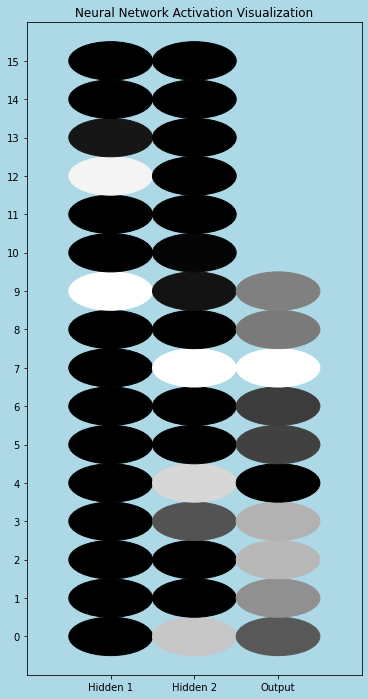

Image 2: True Label = 2, Predicted Label = 2


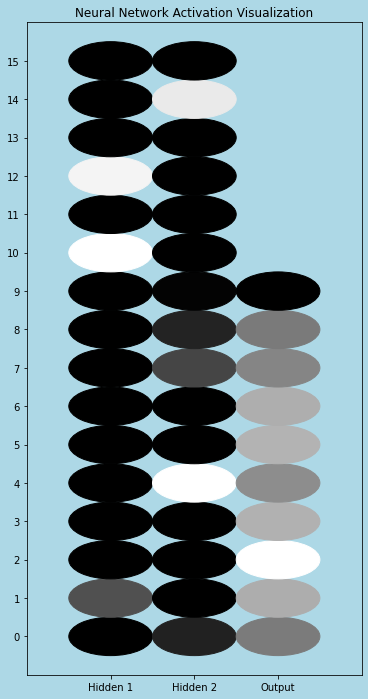

Image 3: True Label = 1, Predicted Label = 1


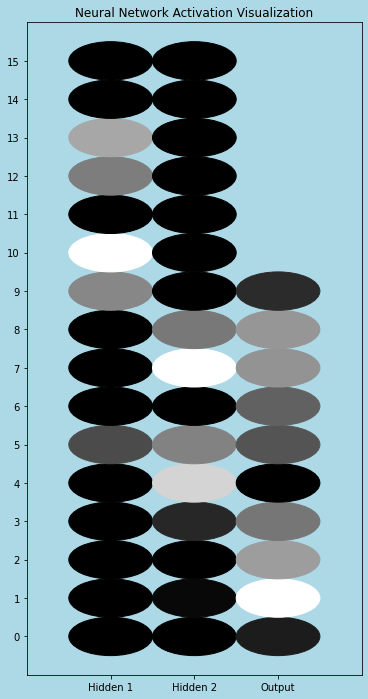

Image 4: True Label = 0, Predicted Label = 0


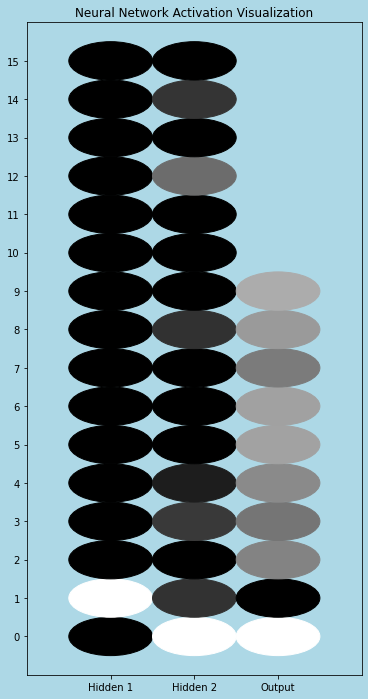

Image 5: True Label = 4, Predicted Label = 4


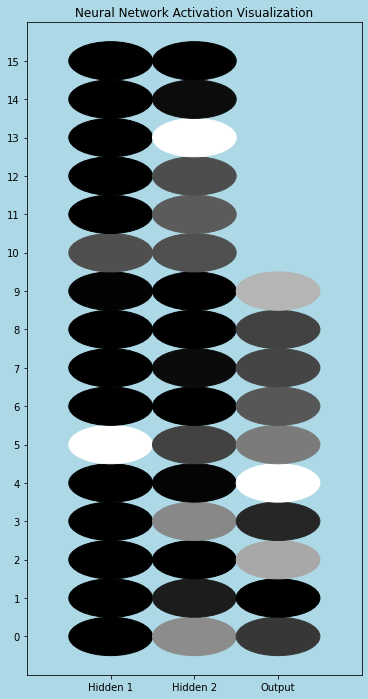

Image 6: True Label = 1, Predicted Label = 1


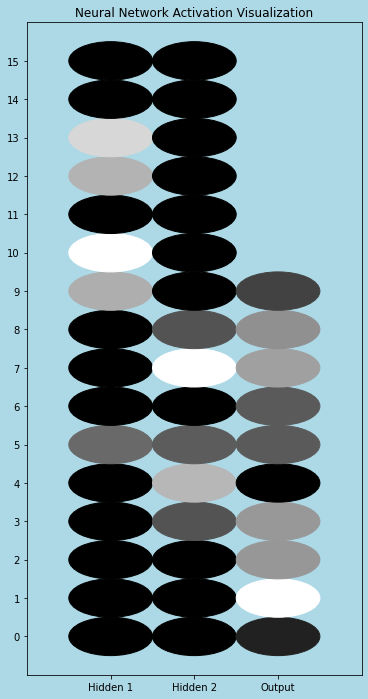

Image 7: True Label = 4, Predicted Label = 4


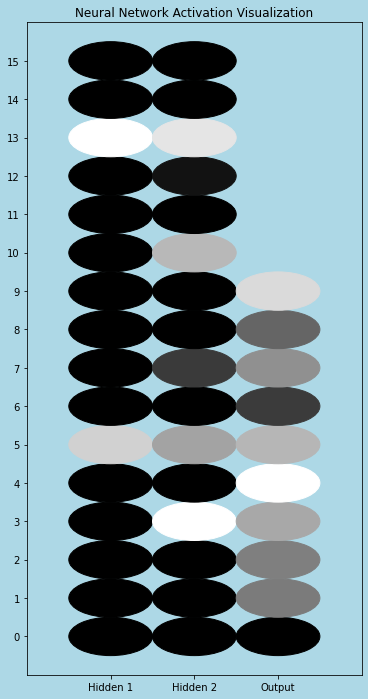

Image 8: True Label = 9, Predicted Label = 9


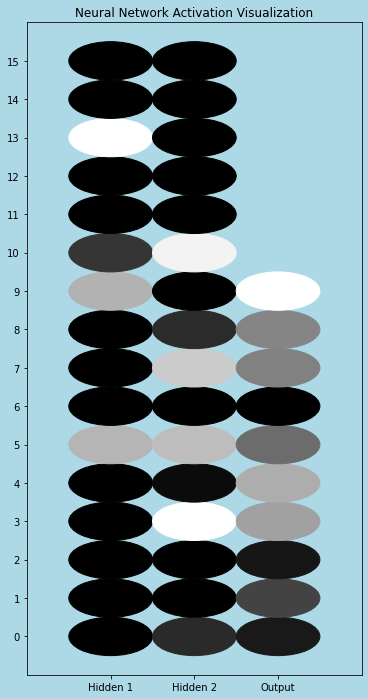

Image 9: True Label = 5, Predicted Label = 6


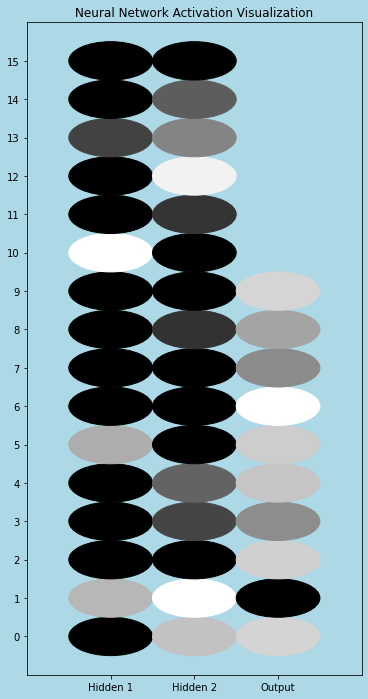

Image 10: True Label = 9, Predicted Label = 9


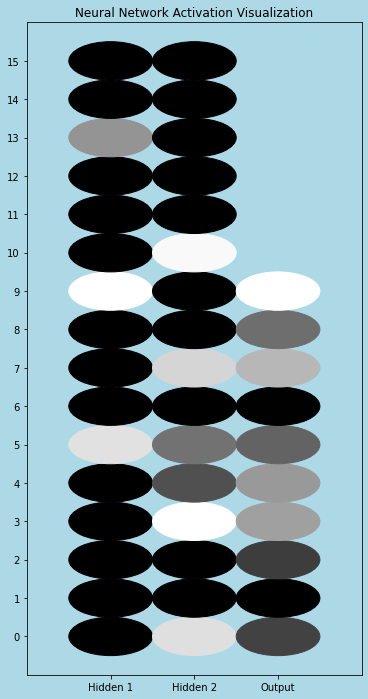

In [39]:
with torch.no_grad():
    for i in range(10):
        # Get single image and label
        image = torch.from_numpy(test_images[i]).float().unsqueeze(0)
        label = test_labels[i]

        # Move to device
        image = image.to(device)

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        # Print results
        print(f"Image {i+1}: True Label = {label}, Predicted Label = {predicted}")

        plot_activations(hidden_one_act, hidden_two_act, classification_out, label)

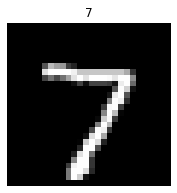

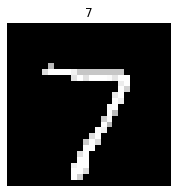

In [50]:
idx = 0

image_np = test_images[idx]
image_np_filt = np.where(image_np >= 180, image_np, 0)

image = torch.from_numpy(image_np).float().unsqueeze(0)
image_filt = torch.from_numpy(image_np_filt).float().unsqueeze(0)
label = test_labels[idx]

visualize_image(image_np, label)
visualize_image(image_np_filt, label)

In [58]:
images = [image, image_filt]
with torch.no_grad():
    for i, img in enumerate(images):
        # Move to device
        img = img.to(device)
        
        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(img)
        
        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()
        
        # Print results
        print(f"Image: True Label = {label}, Predicted Label = {predicted}")

        meta = "normal"
        if i != 0:
            meta = "filt"
        plot_activations(hidden_one_act, hidden_two_act, classification_out, label, True, meta)

Image: True Label = 7, Predicted Label = 7
Image: True Label = 7, Predicted Label = 7
